In [1]:
import numpy as np

import nimare
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset

import nilearn
from nilearn import plotting
import nibabel as nib

from neuromaps.datasets import fetch_annotation
from neuromaps import transforms
from neuromaps import nulls
from neuromaps import stats

import matplotlib.pyplot as plt

# Neurosynth Querying via NiMARE

In [2]:
# Run this a first time to generate the neurosynth dataset
#
# neurosynth_db = fetch_neurosynth(
#     data_dir='.',
#     version="7",
#     source="abstract",
#     vocab="terms",
# )[0]
#
# neurosynth_dset = convert_neurosynth_to_dataset(
#     coordinates_file=neurosynth_db["coordinates"],
#     metadata_file=neurosynth_db["metadata"],
#     annotations_files=neurosynth_db["features"]
# )
#
# # Make sure .neurosynth folder exists in pwd
# neurosynth_dset.save('neurosynth/neurosynth_dataset.pkl.gz')

In [3]:
# Get neurosynth image
ns_dset = nimare.dataset.Dataset.load('neurosynth/neurosynth_dataset.pkl.gz')

ad_dset = ns_dset.slice(
    ns_dset.get_studies_by_label("terms_abstract_tfidf__alzheimer")
)

# Permutation testing
meta = nimare.meta.cbma.ALE(null_method="approximate",   # this is a bit slow
                            kernel__sample_size=20)

meta_results = meta.fit(ad_dset)

# Get neurosynth nifti image
ns_ad = meta_results.get_map("p")
ns_ad = transforms.mni152_to_mni152(ns_ad, '2mm')
ns_ad_affine = ns_ad.affine

# Invert p-values
ns_ad = ns_ad.get_fdata()
ns_ad[np.where(ns_ad == 0)] = 1
ns_ad = np.abs(ns_ad - 1)
ns_ad = nib.Nifti1Image(ns_ad, ns_ad_affine)

In [4]:
# Glu receptor density
smart2019 = fetch_annotation(source='smart2019')
smart2019 = transforms.mni152_to_mni152(smart2019, '2mm')

# Theshold values below zero
smart2019_arr = smart2019.get_fdata()
smart2019_arr[np.where(smart2019_arr < 0)] = 0

smart2019_affine = smart2019.affine
smart2019 = nib.Nifti1Image(smart2019_arr, smart2019_affine)

In [5]:
# Apply GM Mask
gm_mask = nilearn.datasets.load_mni152_gm_mask(threshold=.5, n_iter=1)

gm_mask = transforms.mni152_to_mni152(gm_mask, '2mm')

ns_ad = ns_ad.get_fdata()
ns_ad = ns_ad * gm_mask.get_fdata()
ns_ad = nib.Nifti1Image(ns_ad, ns_ad_affine)

smart2019 = smart2019.get_fdata()
smart2019 = smart2019 * gm_mask.get_fdata()
smart2019 = nib.Nifti1Image(smart2019, smart2019_affine)

/home/rph/Projects/BIRD/.env/lib/python3.8/site-packages/nilearn/datasets/struct.py:431: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  warnings.warn("Default resolution of the MNI template will change "


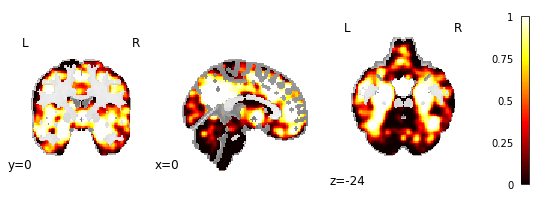

In [6]:
plotting.plot_stat_map(
    ns_ad,
    draw_cross=False,
    cut_coords=[0, 0, -24],
    threshold=0.
)

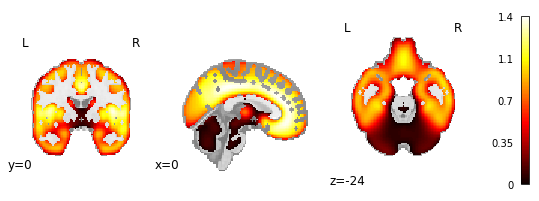

In [7]:
plotting.plot_stat_map(
    smart2019,
    draw_cross=False,
    cut_coords=[0, 0, -24],
    threshold=0.01
)

In [8]:
stats.compare_images(ns_ad, smart2019)

0.5191655000611224